In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
base_dir = 'D:\Weapon Detection Project DRDO\KnivesImagesDatabase' 

In [14]:
# Create image data generators with robust augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

In [6]:
# Setup the training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

Found 13606 images belonging to 2 classes.


In [7]:
# Setup the validation data generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 3401 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Load the base model, pretrained on ImageNet
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True  # Make the model trainable

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom layers on top for the binary classification task
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Include dropout
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
print("Class Indices: ", train_generator.class_indices)

Class Indices:  {'NEGATIVES_ALL': 0, 'POSITIVES_ALL': 1}


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Increased number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping])

# Save the model
model.save('efficient_net_knife_detection_model_ver2.h5')


Epoch 1/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 369s 863ms/step - accuracy: 0.5470 - loss: 0.6891 - val_accuracy: 0.5495 - val_loss: 0.6886
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.5000 - loss: 0.6942 - val_accuracy: 0.4444 - val_loss: 0.7046
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 958s 2s/step - accuracy: 0.5479 - loss: 0.6895 - val_accuracy: 0.5486 - val_loss: 0.6885
Epoch 4/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step - accuracy: 0.4688 - loss: 0.7089 - val_accuracy: 0.7778 - val_loss: 0.6480
Epoch 5/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 422s 990ms/step - accuracy: 0.5484 - loss: 0.6892 - val_accuracy: 0.5483 - val_loss: 0.6890
Epoch 6/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6875 - loss: 0.6664 - val_accuracy: 0.8889 - val_loss: 0.6420
Epoch 7/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 417s 973ms/step - accuracy: 0.5490 - loss: 0.6904 - val_accuracy: 0.5498 - val_loss: 0.6889
Epoch 8/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 0.7019 -

In [15]:
model.save('efficient_net_knife_detection_3.h5')

In [17]:
# Load the saved model
model = tf.keras.models.load_model('D:\Weapon Detection Project DRDO\Models\efficient Net\efficient_net_knife_detection_model_ver2.h5')

# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 61s 542ms/step - accuracy: 0.5644 - loss: 0.6860
Validation Loss: 0.6884883642196655
Validation Accuracy: 0.5492502450942993


In [19]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
model_path = 'D:\Weapon Detection Project DRDO\Models\efficient Net\efficient_net_knife_detection_model_ver2.h5'
base_dir = 'D:\Weapon Detection Project DRDO\KnivesImagesDatabase'  # Update to your dataset path

In [21]:
model = load_model(model_path)

In [22]:
# Data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Include validation_split here

test_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')  # Use the validation subset for evaluation

Found 3401 images belonging to 2 classes.


In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


c:\Users\PRACHI TEWARI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 66s 581ms/step - accuracy: 0.5384 - loss: 0.6902
Test Accuracy: 0.5493
Test Loss: 0.6885


In [24]:
# Predict and print confusion matrix and classification report
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_report = classification_report(y_true, y_pred_classes, target_names=['no_knife', 'knife'])

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 395ms/step
Confusion Matrix:
[[1868    0]
 [1533    0]]

Classification Report:
              precision    recall  f1-score   support

    no_knife       0.55      1.00      0.71      1868
       knife       0.00      0.00      0.00      1533

    accuracy                           0.55      3401
   macro avg       0.27      0.50      0.35      3401
weighted avg       0.30      0.55      0.39      3401



c:\Users\PRACHI TEWARI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PRACHI TEWARI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PRACHI TEWARI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

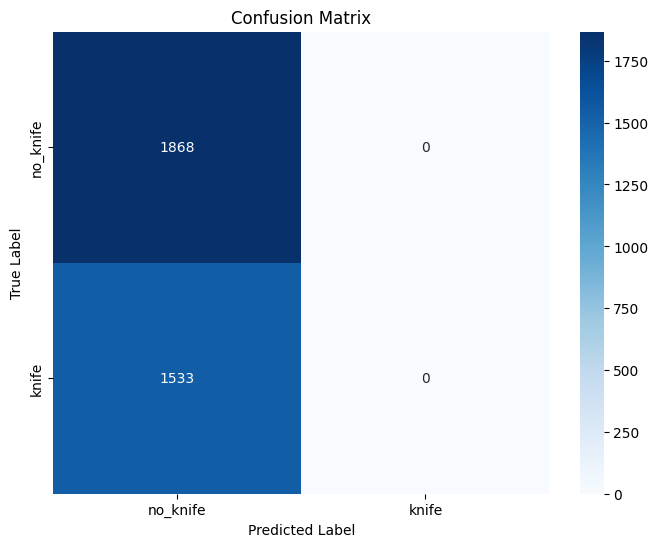

In [25]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['no_knife', 'knife'], yticklabels=['no_knife', 'knife'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

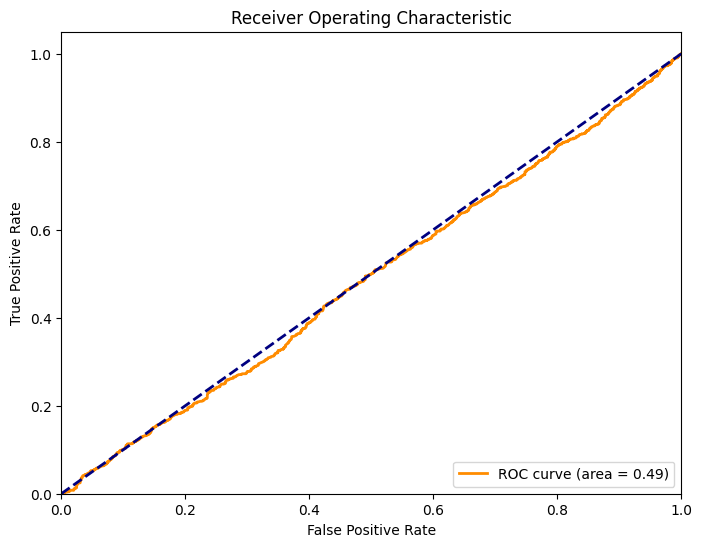

In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

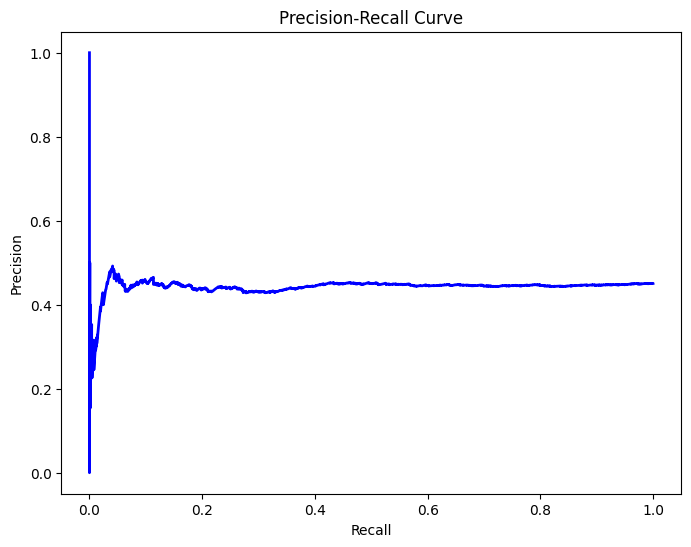

In [27]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()